The user will select a profile region (rectangle). The pixels in the smallest width of the rectangle will be added. Then the profile ploted for each of the image index. This will allow for example to follow the flow of water as it enters a crack.

## 1. Prepare logbook 

In [42]:
from ipywidgets import widgets
from IPython.display import display

from pprint import pprint
from ipywidgets.widgets import interact

import os, os.path
import datetime
import glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

import matplotlib as mpl
from PyQt4 import QtGui

font = {'family' : 'monospace',
       'size' : '14'}
mpl.rc('font', **font)

from PIL import Image
import numpy as np
import pandas as pd

## 2. Select Data Files

In [43]:
default_dir = '/Volumes/My Book Thunderbolt Duo/IPTS/IPTS-16259/'

In [44]:
try:
    from PySide import QtCore, QtGui
except ImportError:
    from PyQt4 import QtCore, QtGui

def gui_dname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, "Select Data Files Folder ...",
                                                   dir)
                                                 
    return dir_name

In [45]:
%gui qt
folder_name = gui_dname(dir = default_dir)
list_files = glob.glob(folder_name + '/*.tiff')

## 3. Load the data 

In [46]:
w = widgets.IntProgress()
w.max = len(list_files)
display(w)
index = 0

array_images = []
for ref, file in enumerate(list_files):
    _image = np.asarray(Image.open(file))
    array_images.append(_image)
    index += 1
    w.value = index

## 4. Select Range of Image to Work On 

Using the Image Index (*image_index*) slider, narrow down the range of images that we will use in the analysis. Make sure you play wit the **min_intensity** and **max_intensity** to change the contrast of the images. 

### a. Default Contrast  and Profile Range

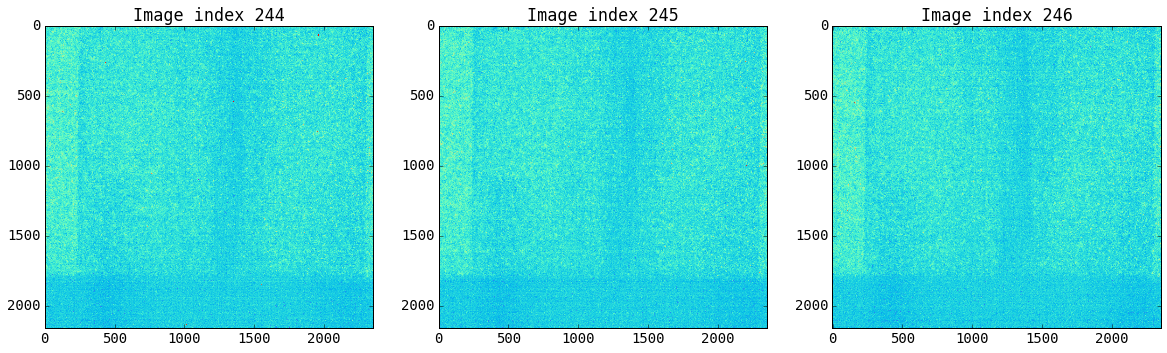

In [41]:
min_intensity = 82
max_intensity = 143

def plot_images(file_index):
    
    data_left = array_images[file_index-1]
    data      = array_images[file_index]
    data_right = array_images[file_index+1]
    
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1,3)
    
    ax_img = plt.subplot(gs[0,0])
    ax_img.imshow(data_left, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index-1))

    ax_img = plt.subplot(gs[0,1])
    ax_img.imshow(data, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
#    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    ax_img.set_title("Image index %d" %file_index)
    

    ax_img = plt.subplot(gs[0,2])
    ax_img.imshow(data_right, cmap='rainbow', 
                  interpolation=None,
                  vmin=min_intensity, 
                  vmax=max_intensity)
    ax_img.set_title("Image index %d" %(file_index+1))
    

    
number_of_files = len(list_files)
range_selection = interact(plot_images,
                          file_index = widgets.IntSlider(min=1, 
                                                         max=number_of_files-2, 
                                                         value=35, 
                                                         step=1, 
                                                         description="Image Index"))


### b. Image range

Using previous plot, you determined that the range of images of interest is between:


In [26]:
first_image_index = 35
last_image_index = 80

In [27]:
[image_height, image_width] = array_images[0].shape
working_array_images = array_images[first_image_index : last_image_index+1]
working_list_files = list_files[first_image_index : last_image_index+1]

## 5. Normalize data

The data will be all normalized by using the first image. Each image will be divided by the first image.

In [28]:
normalization_image = list_files[0]
normalization_data = array_images[0]

_list_files = working_list_files

w = widgets.IntProgress()
w.max = len(_list_files)
display(w)
index = 0

normalized_array_images = []
for _image in working_array_images:
    _normalized_image = _image / normalization_data
    normalized_array_images.append(_normalized_image)
    index += 1
    w.value = index

Clear memory

In [29]:
del(array_images[:])
del(array_images)

## 6. Select Profile Region 

default_profile_range

In [30]:
min_intensity = 0
max_intensity = 1

In [31]:
x_left = 1234
y_top = 0
width = 34
height = 2159

[1234, 0, 34, 2159, <matplotlib.figure.Figure at 0x116275198>]

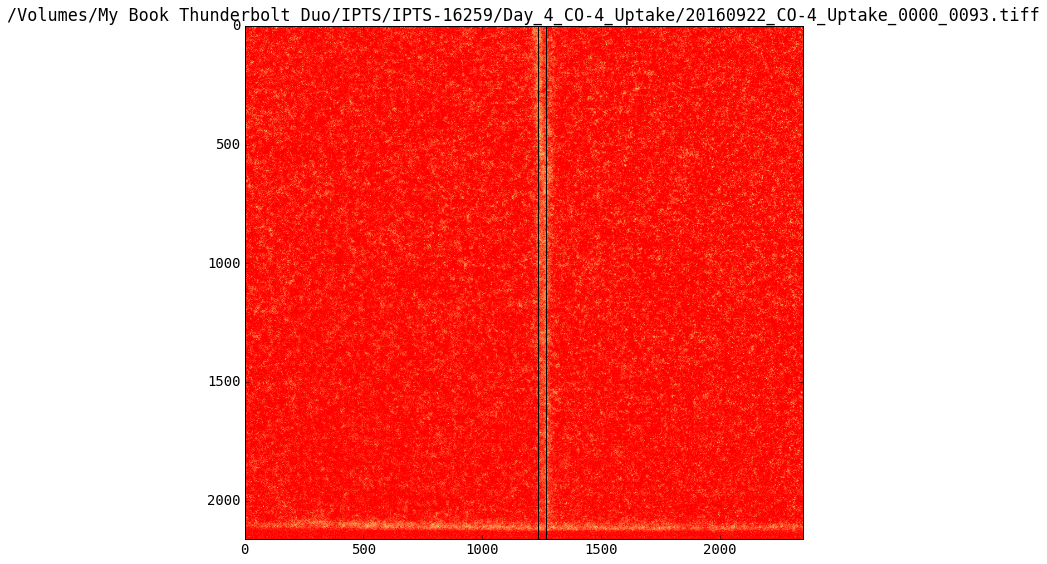

In [32]:
def plot_images_with_box(file_index, x_left, y_top, width, height):
    
    data = normalized_array_images[file_index][:, :]
    
    fig_box = plt.figure(figsize=(10, 10))
    ax_img = plt.subplot(111)
    
    ax_img.imshow(data, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])
    ax_img.add_patch(patches.Rectangle((x_left, y_top), width, height, fill=False))
    
    return [x_left, y_top, width, height, fig_box]

number_of_files = len(list_files)
profile = interact(plot_images_with_box,
                  file_index = widgets.IntSlider( min=0, max=len(working_list_files), 
                                                 value=42, step=1, 
                                                 description='Image index'),
                  x_left = widgets.IntSlider( min=0, max=image_width-1, step=1, value= x_left),
                  y_top = widgets.IntSlider( min=0, max=image_height-1, step=1, value= y_top), 
                  width = widgets.IntSlider( min=0, max=image_width-1, step=1, value= width), 
                  height = widgets.IntSlider( min=0, max=image_height-1, step=1, value=height))
    

## 7. calculate profile over range of images 

In [33]:
print(profile.widget.kwargs)
y_top = profile.widget.kwargs['y_top']
x_left = profile.widget.kwargs['x_left']
width = profile.widget.kwargs['width']
height = profile.widget.kwargs['height']

{'y_top': 0, 'x_left': 1234, 'width': 34, 'height': 2159, 'file_index': 42}


In [34]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0

profile_array = []
for _image in normalized_array_images:
    _profile_image = _image[y_top:y_top+height, x_left:x_left+width]
    _value = np.sum(_profile_image)
    profile_array.append(_value)
    w.value = index
    index += 1

## 8. Display global profile 

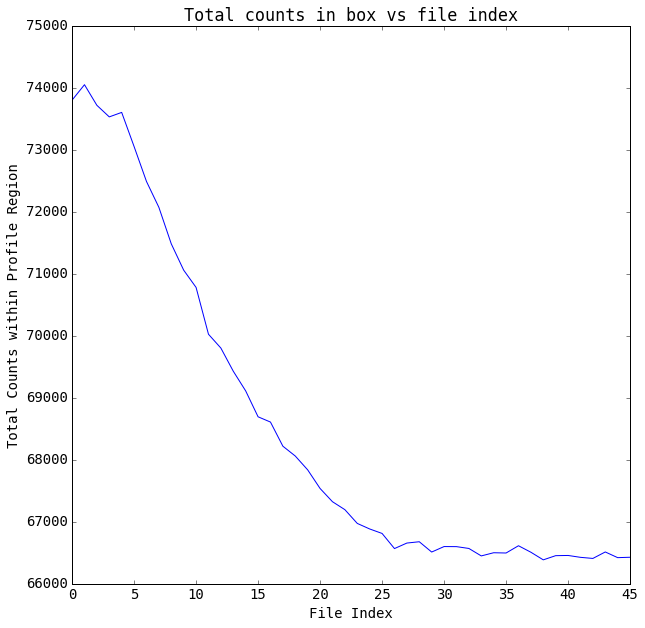

In [35]:
fig_profile = plt.figure(figsize=(10, 10))
plt.plot(profile_array)  
plt.title("Total counts in box vs file index")
plt.xlabel("File Index")
plt.ylabel("Total Counts within Profile Region")

## 9. Display Profile vs File Index  

In order to improve the statitics, **rebin** allows to combine those pixels in the y-direction. 

In [36]:
rebin = 3  #number of pixels in y direction to rebin (to improve statistic)

Calculate the profile
 - rebin the pixels as defined by the **rebin** parameter along the y-axis
 - sum all the pixels along the x-axis

In [37]:
w = widgets.IntProgress()
w.max = len(working_list_files)-1
display(w)
index = 0
rebin_range = np.arange(0, height-y_top, rebin)

profile_1d = []
def calculate_1d_profiles():
    
    for _index, _array in enumerate(normalized_array_images):
        _roi_array = _array[y_top:y_top+height, x_left:x_left+width]
        _width_profile = np.sum(_roi_array,1)
        rebin_width_profile = [sum(_width_profile[x:x+rebin]) for x in rebin_range]
        profile_1d.append(rebin_width_profile)
        _index += 1
        w.value = _index
    
calculate_1d_profiles()

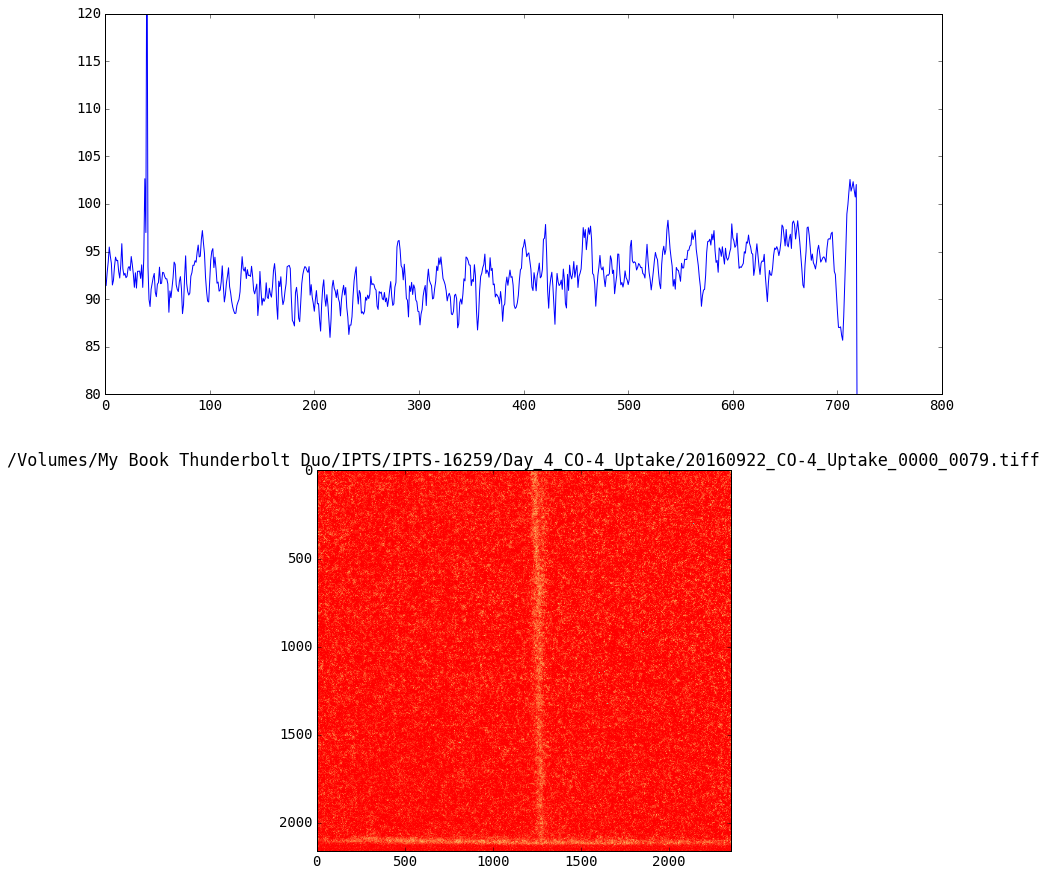

In [38]:
counts_max = 120
counts_min = 80

def plot_profile(file_index):
    
    data_1d = profile_1d[file_index]
    data_2d = normalized_array_images[file_index]
    
    fig = plt.figure(figsize=(15,15))
    
    plt.subplot(211)
    plt.plot(data_1d)
    plt.ylim([counts_min, counts_max])
    
    ax_img = plt.subplot(212)
    ax_img.imshow(data_2d, cmap = 'rainbow',
                  interpolation = None,
                  vmin = min_intensity,
                  vmax = max_intensity)
    ax_img.set_title(working_list_files[file_index])

number_of_files = len(working_list_files)
range_selection = interact(plot_profile,
                          file_index = widgets.IntSlider(min=0, 
                                                         max=number_of_files-1, 
                                                         value=0, 
                                                         step=1, 
                                                         description="Image Index"))

## 10. Load file vs time stamp 

In [82]:
def gui_fname(dir=None):
    """Select a directory
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getOpenFileName(None, 
                                                 "Select txt data file ...",
                                                  dir,
                                                  filter = "ascii (*.txt)",
)
                                                 
    return dir_name

In [83]:
%gui qt
file_vs_timestamp_file = gui_fname(dir = default_dir)
#pprint(file_vs_file)

In [120]:
df = pd.read_csv(file_vs_timestamp_file)

In [121]:
df.head()

,#FileName,timeStamp_s,timeOffset_ms
0,20160922_CO-4_Uptake_0000_0015.tiff,1.474583e+09,0.000000
1,20160922_CO-4_Uptake_0000_0016.tiff,1.474583e+09,33.401489
2,20160922_CO-4_Uptake_0000_0017.tiff,1.474583e+09,66.128969
3,20160922_CO-4_Uptake_0000_0018.tiff,1.474583e+09,99.081278
4,20160922_CO-4_Uptake_0000_0019.tiff,1.474583e+09,132.167816


In [122]:
# trying to locate a value knowing the name of file
FileNameColumn = df['#FileName']
#print(FileNameColumn)
result = df.loc[df['#FileName'] == '20160922_CO-4_Uptake_0000_0015.tiff']
time_stamp = print(result.values[0][1])

1474582705.2265878


In [135]:
list_file_name = df['#FileName'].values
list_column = df.columns.values
list_time_stamp = df[list_column[1]].values

## 11. Output profiles of previous image index selected

In [140]:
image_index = range_selection.widget.kwargs['file_index']
current_file = working_list_files[image_index]
current_profile = profile_1d[image_index]

In [141]:
def gui_fname(dir=None):
    """Select a filename
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getSaveFileName(None, "Define output file name",
                                                  dir)
                                                 
    return dir_name

In [142]:
%gui qt
ascii_file = gui_fname(dir = default_dir)
#pprint(ascii_file)

In [150]:
time_0 = list_time_stamp[first_image_index]

def create_ascii_contain(image_index):
    ascii_contain = []
    ascii_contain.append("#File display: {}\n".format(working_list_files[image_index]))
    ascii_contain.append("#ROI selected (y0,x0,height,width):({},{},{},{})\n".format(y_top, x_left, height, width))
    ascii_contain.append("#Rebin in y direction: {}\n".format(rebin))
    _time_stamp = list_time_stamp[image_index + first_image_index]
    _time_stamp_str = datetime.datetime.fromtimestamp(_time_stamp).strftime("%Y-%m-%d %H:%M:%S")
    ascii_contain.append("#Time stamp: {}\n".format(_time_stamp_str))
    _delta_time = _time_stamp - time_0
    ascii_contain.append("#Delta time (s): {}\n".format(_delta_time))
    ascii_contain.append("#\n")
    ascii_contain.append("#Label: pixel_index, counts\n")
    for index, value in enumerate(profile_1d[image_index]):
        ascii_contain.append("{}, {}\n".format(index, value))
    return ascii_contain

ascii_contain = create_ascii_contain(image_index)
if ascii_file:
    f = open(ascii_file, 'w')
    for _line in ascii_contain:
        f.write(_line)
    f.close()        


## 12. Output profiles of all images

In [151]:
def gui_dname(dir=None):
    """Select folder
    """
    if dir is None: dir ='./'
    dir_name = QtGui.QFileDialog.getExistingDirectory(None, "Select Folder where to Output all the Profiles ...",
                                                  dir,
                                                  QtGui.QFileDialog.ShowDirsOnly)
    return dir_name

In [152]:
%gui qt
dir_name = gui_dname(dir = default_dir)
%matplotlib inline

In [153]:
def output_ascii_file(filename = None, data = None):
    f = open(filename, 'w')
    for _line in data:
        f.write(_line)
    f.close()

In [154]:
raw_file_name = 'profile1d_'
for _index, _profile in enumerate(profile_1d):
    output_file_name = os.path.join(dir_name, 'raw_file_name_' + str(_index) + '.txt')
    ascii_contain = create_ascii_contain(_index)
    output_ascii_file(filename = output_file_name, data = ascii_contain)